In [1]:
import $ivy.`com.stripe::rainier-core:0.3.3`
import $ivy.`com.stripe::rainier-notebook:0.3.3`

import $ivy.$                               

import $ivy.$                                   

In [2]:
import com.stripe.rainier.compute._
import com.stripe.rainier.core._
import com.stripe.rainier.sampler._
import com.stripe.rainier.notebook._

import com.stripe.rainier.compute._

import com.stripe.rainier.core._

import com.stripe.rainier.sampler._

import com.stripe.rainier.notebook._

In [3]:
PPrint.register(repl)

In [4]:
import $ivy.`com.github.tototoshi::scala-csv:1.3.6`
import com.github.tototoshi.csv._
import java.io.File

import $ivy.$                                      

import com.github.tototoshi.csv._

import java.io.File

In [5]:
def time[R](block: => R): R = {
    val t0 = System.nanoTime()
    val result = block    // call-by-name
    val t1 = System.nanoTime()
    val timeMilis = ((t1 - t0) / 1e6).toInt
    println(s"Elapsed time: $timeMilis ms")
    result
}

defined function time

In [6]:
val countriesSmooth = {
    val csvReader = CSVReader.open(new File("data/smooth_countries.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesSmooth: List[Map[String, String]] = List(
  Map("country" -> "Austria", "date" -> "2020-03-09", "cases" -> "27"),
  Map("country" -> "Austria", "date" -> "2020-03-10", "cases" -> "39"),
  Map("country" -> "Austria", "date" -> "2020-03-11", "cases" -> "56"),
  Map("country" -> "Austria", "date" -> "2020-03-12", "cases" -> "79"),
  Map("country" -> "Austria", "date" -> "2020-03-13", "cases" -> "107"),
  Map("country" -> "Austria", "date" -> "2020-03-14", "cases" -> "131"),
  Map("country" -> "Austria", "date" -> "2020-03-15", "cases" -> "161"),
  Map("country" -> "Austria", "date" -> "2020-03-16", "cases" -> "193"),
  Map("country" -> "Austria", "date" -> "2020-03-17", "cases" -> "243"),
  Map("country" -> "Austria", "date" -> "2020-03-18", "cases" -> "299"),
  Map("country" -> "Austria", "date" -> "2020-03-19", "cases" -> "354"),
  Map("country" -> "Austria", "date" -> "2020-03-20", "cases" -> "409"),
  Map("country" -> "Austria", "date" -> "2020-03-21", "cases" -> "477"),
  Ma

In [7]:
val countriesOnsetData = {
    val csvReader = CSVReader.open(new File("data/onset.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

countriesOnsetData: List[Map[String, String]] = List(
  Map("country" -> "Austria", "date" -> "2019-10-27", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-10-28", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-10-29", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-10-30", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-10-31", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-01", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-02", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-03", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-04", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-05", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-06", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-07", "Onset" -> "0.0"),
  Map("country" -> "Austria", "date" -> "2019-11-08", "Onset" -> "0.0"

In [8]:
val pdelayData = {
    val csvReader = CSVReader.open(new File("data/pdelay.csv"))
    val xs = csvReader.allWithHeaders()
    csvReader.close()
    xs
}

pdelayData: List[Map[String, String]] = List(
  Map("index" -> "0", "pdelay" -> "0.006547041707080504"),
  Map("index" -> "1", "pdelay" -> "0.04194956353055286"),
  Map("index" -> "2", "pdelay" -> "0.05771096023278371"),
  Map("index" -> "3", "pdelay" -> "0.06983511154219205"),
  Map("index" -> "4", "pdelay" -> "0.07153249272550921"),
  Map("index" -> "5", "pdelay" -> "0.08583899127061105"),
  Map("index" -> "6", "pdelay" -> "0.07953443258971872"),
  Map("index" -> "7", "pdelay" -> "0.07516973811833172"),
  Map("index" -> "8", "pdelay" -> "0.07710960232783705"),
  Map("index" -> "9", "pdelay" -> "0.07904946653734239"),
  Map("index" -> "10", "pdelay" -> "0.06304558680892337"),
  Map("index" -> "11", "pdelay" -> "0.0511639185257032"),
  Map("index" -> "12", "pdelay" -> "0.04485935984481086"),
  Map("index" -> "13", "pdelay" -> "0.038554801163918524"),
  Map("index" -> "14", "pdelay" -> "0.028855480116391854"),
  Map("index" -> "15", "pdelay" -> "0.026430649854510185"),
  Map("index" -> 

In [9]:
val pdelay = pdelayData.collect { case m => m("pdelay").toDouble }
val cumulative_pdelay = pdelay.scanLeft(0.0)((x: Double, y: Double) => x+y).drop(1)

pdelay: List[Double] = List(
  0.006547041707080504,
  0.04194956353055286,
  0.05771096023278371,
  0.06983511154219205,
  0.07153249272550921,
  0.08583899127061105,
  0.07953443258971872,
  0.07516973811833172,
  0.07710960232783705,
  0.07904946653734239,
  0.06304558680892337,
  0.0511639185257032,
  0.04485935984481086,
  0.038554801163918524,
  0.028855480116391854,
  0.026430649854510185,
  0.01915615906886518,
  0.02061105722599418,
  0.011881668283220174,
  0.009456838021338506,
  0.009699321047526674,
  0.006547041707080504,
  0.004122211445198836,
  0.0036372453928225023,
  0.002909796314258002,
  0.0036372453928225023,
  0.0019398642095053346,
  4.8496605237633366E-4,
  4.8496605237633366E-4,
  0.0,
  9.699321047526673E-4,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
  0.001454898157129001,
  2.4248302618816683E-4,
  4.8496605237633366E-4,
  7.274490785645005E-4,
...
cumulative_pdelay: List[Double] = List(
  0.006547041707080504,
  0.0484966052

In [10]:
def prepareDataForModel(xs: List[Long]): List[((Int, Long), Long)] = {
    val adjacentPairs = xs.drop(1).zip(xs.take(xs.size - 1))
    adjacentPairs.zipWithIndex.map{case ((kt, kt_prev), i) =>
        (i, kt_prev) -> kt
    }
}

defined function prepareDataForModel

Preparation of the other model

In [11]:
import scala.collection.mutable.ListBuffer

def prepareDataForModelOnset(xs: List[Long], pd: List[Double]): List[(Long,Double)] = {
    val cpd = pd.scanLeft(0.0)(_+_).tail
    val cpdPadded = List.fill(xs.size - pd.size)(1.0) ++ cpd.reverse
    xs.map(_+1).zip(cpdPadded)
}

import scala.collection.mutable.ListBuffer


defined function prepareDataForModelOnset

In [12]:
val L = (1L to 100L).toList
val pd = pdelay
val test = prepareDataForModelOnset(L.takeRight(5), pd)

L: List[Long] = List(
  1L,
  2L,
  3L,
  4L,
  5L,
  6L,
  7L,
  8L,
  9L,
  10L,
  11L,
  12L,
  13L,
  14L,
  15L,
  16L,
  17L,
  18L,
  19L,
  20L,
  21L,
  22L,
  23L,
  24L,
  25L,
  26L,
  27L,
  28L,
  29L,
  30L,
  31L,
  32L,
  33L,
  34L,
  35L,
  36L,
  37L,
  38L,
...
pd: List[Double] = List(
  0.006547041707080504,
  0.04194956353055286,
  0.05771096023278371,
  0.06983511154219205,
  0.07153249272550921,
  0.08583899127061105,
  0.07953443258971872,
  0.07516973811833172,
  0.07710960232783705,
  0.07904946653734239,
  0.06304558680892337,
  0.0511639185257032,
  0.04485935984481086,
  0.038554801163918524,
  0.028855480116391854,
  0.026430649854510185,
  0.01915615906886518,
  0.02061105722599418,
  0.011881668283220174,
  0.009456838021338506,
  0.009699321047526674,
  0.006547041707080504,
  0.004122211445198836,
  0.0036372453928225023,
  0.002909796314258002,
  0.0036372453928225023,
  0.0019398642095053346,
  4.8496605237633366E-4,
  4.8496605237633366E-4,
  0.0,

In [13]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
    override val iterations = 1000
}

samplerConfig: DefaultConfig{def massMatrixTuner(): com.stripe.rainier.sampler.IdentityMassMatrixTuner;def sampler(): com.stripe.rainier.sampler.HMCSampler} = ammonite.$sess.cmd12$Helper$$anon$1@69e49e9b

Define a function that we'll use to retry the call to Rainier's `predict` that fails occassionally. Fortunately, the failure can be easily detected and 1-2 retries solves the issue.

In [14]:
def retry[T](maxAttempts: Int, isSuccessful: T => Boolean)(f: => T): T = {
    var i = 0
    
    do {
        val res = f
        i = i + 1
        if (isSuccessful(res))
            return res
        println(s"WARN: Attempt[$i] failed. Retrying...")
    } while (i < maxAttempts)
    sys.error("Exceeded maximum number of retries")
}

defined function retry

Fixed the parameters for all distributions

In [15]:
def predictRt(caseNumbers: List[Long]): (Vec[Real], List[Seq[Double]]) = {
    val data = prepareDataForModel(caseNumbers)
    
    val (model, rts) =  {
        val (xs, ys) = data.unzip

        val serialInterval = Normal(5,2).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
            val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
            Poisson(lambda)
        }

        (Model.observe(ys, likelihoods), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRt

In [16]:
case class RtModelEstimates(rts: Vec[Real], 
                            rtsEstimates: List[Seq[Double]], 
                            serialInterval: Real, 
                            serialIntervalEstimates: Seq[Double])

defined class RtModelEstimates

In [17]:

def predictRtOnsetLogProcess(onsetNumbers: List[Long], pdelay: List[Double]): (Vec[Real], List[Seq[Double]]) = {
    
    val data = prepareDataForModelOnset(onsetNumbers, pdelay)
    
    val (model, rts) =  {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6,1.5).latent
        val logR0 = Normal(0, 1).latent
        val sigma = Exponential(10).latent
        val diffs = Laplace(0,sigma).latentVec(data.size)
        val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest*cpd*((logRts(i).exp - 1)/serialInterval).exp
            Poisson(lambda)
        }
        (Model.observe(onset.drop(1), expectedToday), logRts.map(_.exp))
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 4)
    }
    
    rts -> trace.predict(rts)
}

defined function predictRtOnsetLogProcess

In [18]:
// direct (and faithful) translation of Systrom's MCMC model from
// Realtime Rt mcmc.ipynb
def predictRtOnset(onsetNumbers: List[Long], pdelay: List[Double], failedRunDetection: Boolean = true): RtModelEstimates = {
    
    val data = prepareDataForModelOnset(onsetNumbers, pdelay)
    
    val (model, rts, serialInterval) = {
        val (onset, cum_pdelay) = data.unzip
        val serialInterval = Gamma(6,1/1.5).latent
        val sigma = Normal(0,0.03).latent.abs
        val Theta0 = Normal(0.1,0.1).latent
        val diffs = Laplace(0,sigma).latentVec(data.size) // Maybe normal would be better
        val ThetaT = Vec.from(diffs.toList.scanLeft(Theta0)(_ + _))
        val Rts = ThetaT.map(_*serialInterval + 1)
        val inferredYesterday = data.take(data.size-1).map { case (o_t, cp_t) => 
            o_t/cp_t 
        }.zipWithIndex
        val expectedToday = Vec.from(inferredYesterday.zip(cum_pdelay.drop(1))).map { case ((infYest, i), cpd) =>
            val lambda = infYest * cpd * (ThetaT(i).exp)
            Poisson(lambda)
        }
        
        val obsModel = Model.observe(onset.drop(1), expectedToday)
        val trackSerialInterval = Model.track(Set(serialInterval))
        (obsModel.merge(trackSerialInterval), Rts, serialInterval)
    }
    
    def detectFailedRun(trace: Trace): Boolean =
        // from: https://twitter.com/avibryant/status/1253049509128499201
        !failedRunDetection || trace.diagnostics.map(_.rHat).max < 1.1
    
    val trace = retry(maxAttempts = 3, isSuccessful = detectFailedRun) {
        model.sample(samplerConfig, 2)
    }

    RtModelEstimates(rts = rts, 
                 rtsEstimates = trace.predict(rts),
                 serialInterval = serialInterval,
                 serialIntervalEstimates = trace.predict(serialInterval))
}

defined function predictRtOnset

In [19]:
case class RtsDistributionStats(means: Seq[(Int, Double)], hdpis: Seq[(Int, (Double, Double))])
def distributionStats(rts: Vec[Real], rtForecasts: List[Seq[Double]]): RtsDistributionStats = {
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    RtsDistributionStats(means, hdpis)
}

defined class RtsDistributionStats
defined function distributionStats

Chain 1 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.75 E-BFMI: 0.73 Step size: 0.02 Total gradient evaluations: 2e+05 (42us) Total time: 18s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.90 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (44us) Total time: 17s

Elapsed time: 37157 ms


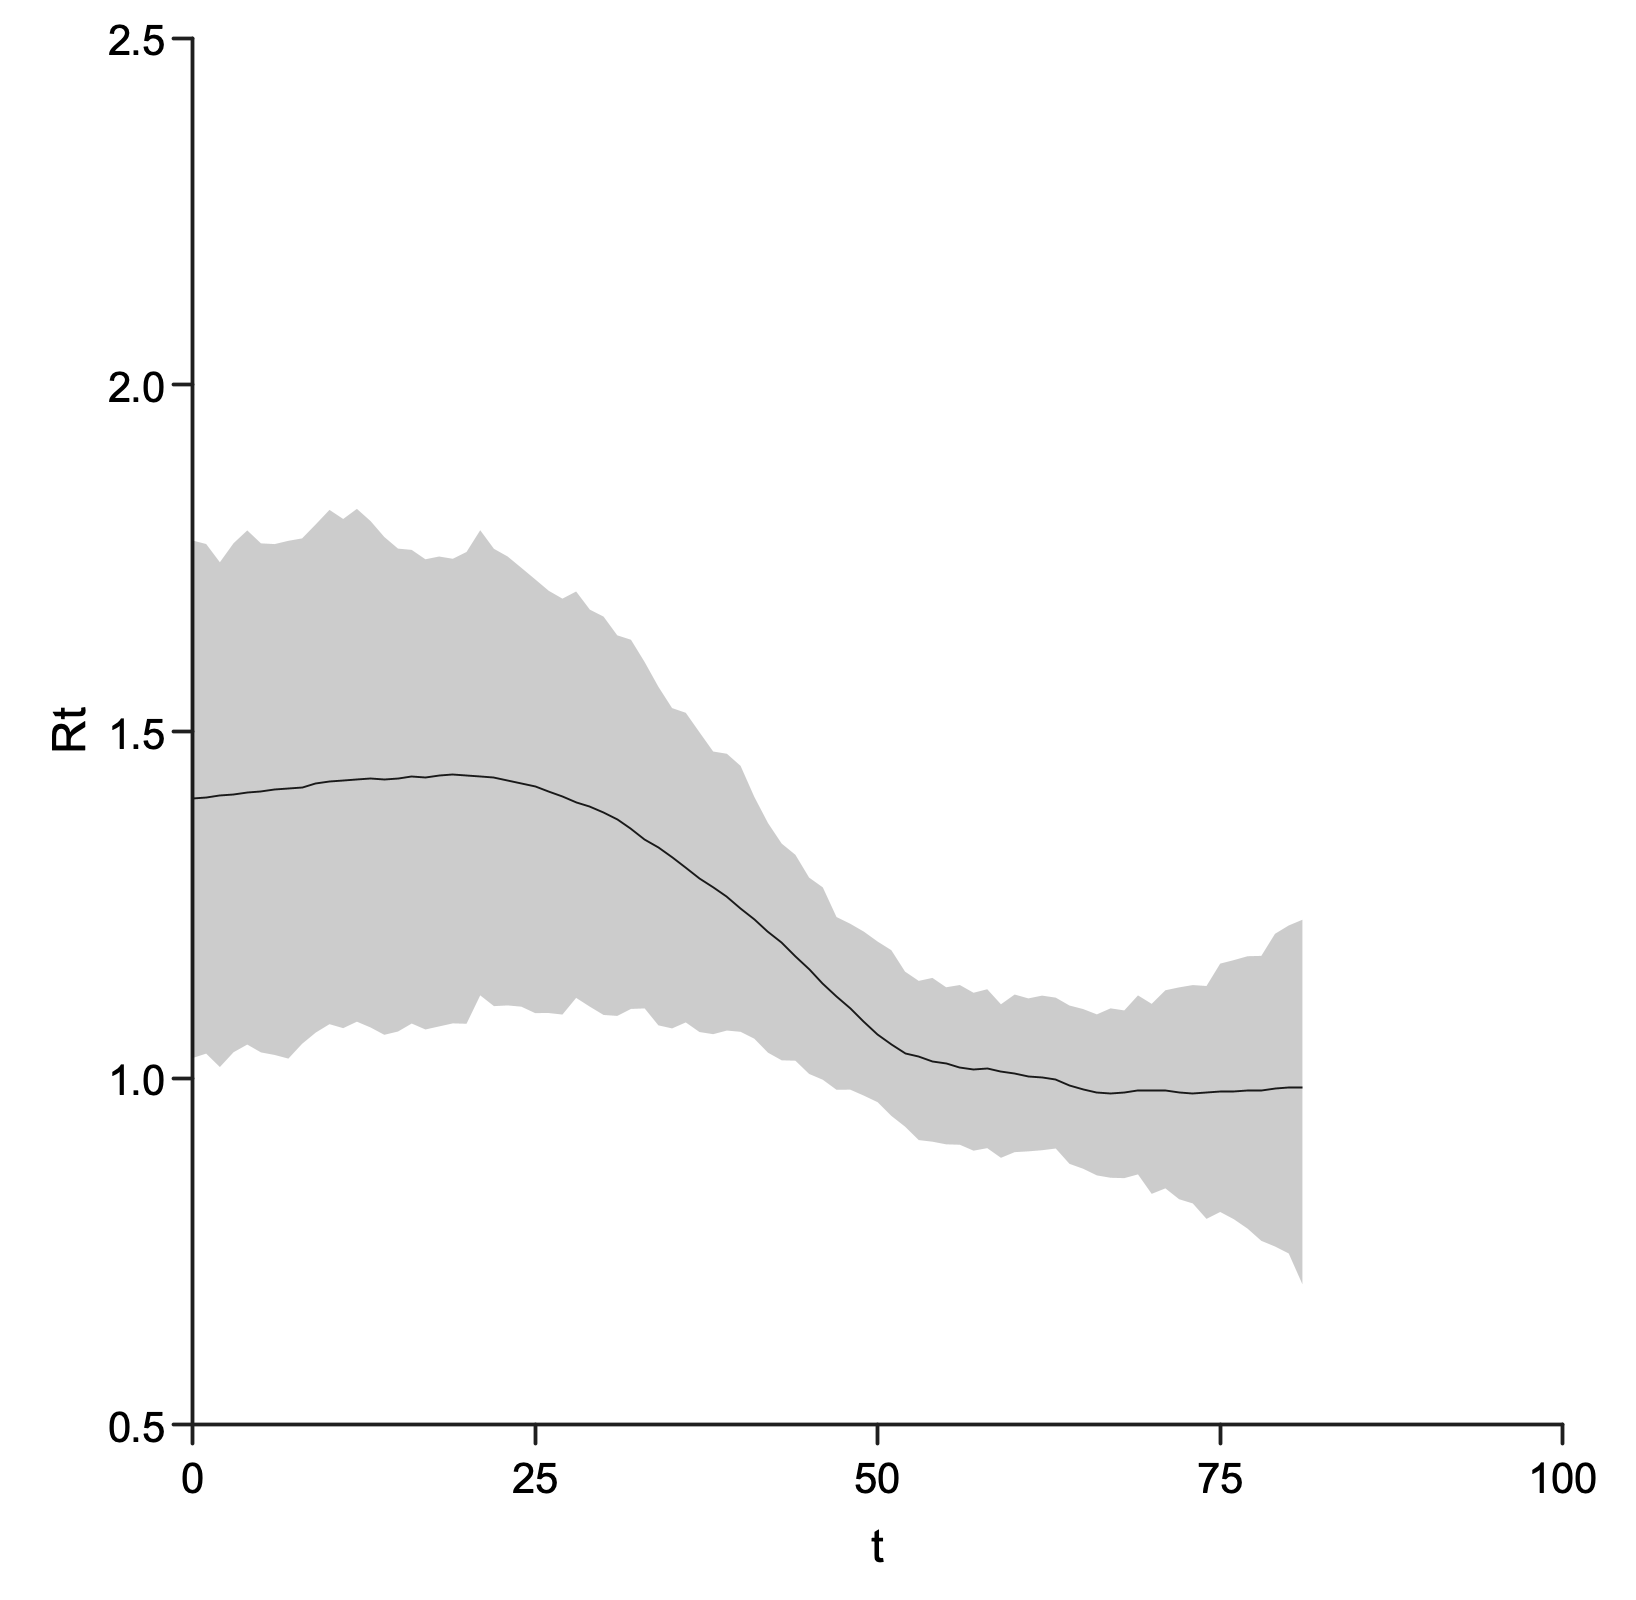

In [20]:
{{
    val countryName = "Poland"
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates,_, _) = time { 
//         val res = predictRtOnset(onsetNumbers.dropRight(5).takeRight(60), pdelay)
        val res = predictRtOnset(onsetNumbers.dropWhile(_ == 0.0), pdelay, failedRunDetection = false)
        res
    }
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
}}

In [21]:
val countriesToPredict = countriesOnsetData.map(_("country")).toSet //smaller set: Seq("Poland", "France", "Italy", "Germany", "Czechia")

countriesToPredict: Set[String] = Set(
  "Poland",
  "Croatia",
  "Luxembourg",
  "Greece",
  "Spain",
  "Russia",
  "Estonia",
  "Czechia",
  "Romania",
  "Denmark",
  "Belgium",
  "Slovenia",
  "Malta",
  "Slovakia",
  "Finland",
  "Lithuania",
  "Sweden",
  "United_Kingdom",
  "Austria",
  "Latvia",
  "Italy",
  "Ireland",
  "Bulgaria",
  "Norway",
  "France",
  "Netherlands",
  "Switzerland",
  "Cyprus",
  "Germany",
  "Portugal",
  "Hungary"
)

In [53]:
val countryStats: Map[String, RtsDistributionStats] = {
    assert(countriesToPredict.toSet.subsetOf(countriesSmooth.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesSmooth.collect {
                case m if m("country") == countryName => m("cases").toLong
            }
            val (rts,estimates) = predictRt(caseNumbers)
            val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
            println(s"$countryName [done]")
            countryName -> stats
        }.seq
    }
    allStats.toMap
}

: 

In [27]:
import scala.util.Try

val countryStatsOnset: Map[String, Either[Throwable, RtsDistributionStats]] = {
    assert(countriesToPredict.toSet.subsetOf(countriesOnsetData.map(_("country")).toSet))
    val allStats = time {
        countriesToPredict.par.map { countryName =>
            val caseNumbers = countriesOnsetData.collect {
                case m if m("country") == countryName => m("Onset").toDouble.round
            }
            val possiblyFailed: Try[RtsDistributionStats] = Try { 
               val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = predictRtOnset(caseNumbers.takeRight(50), pdelay)
               val stats@RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
               println(s"$countryName [done]")
               stats
            }
            countryName -> possiblyFailed.toEither
        }.seq
    }
    allStats.toMap
}

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.83 E-BFMI: 0.66 Step size: 0.05 Total gradient evaluations: 2e+05 (32us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.81 E-BFMI: 0.52 Step size: 0.01 Total gradient evaluations: 2e+05 (39us) Total time: 16s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.88 E-BFMI: 0.58 Step size: 0.01 Total gradient evaluations: 2e+05 (33us) Total time: 16s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.85 E-BFMI: 0.62 Step size: 0.05 Total gradient evaluations: 2e+05 (32us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.87 E-BFMI: 0.61 Step size: 0.04 Total gradient evaluations: 2e+05 (31us) Total time: 16s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.84 E-BFMI: 0.70 Step size: 0.04 Total gradient evaluations: 2e+05 (50us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.03 Total gradient evaluations: 2e+05 (134us) Total time: 16s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.83 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (40us) Total time: 16s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.84 E-BFMI: 0.53 Step size: 0.02 Total gradient evaluations: 2e+05 (31us) Total time: 16s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.89 E-BFMI: 0.64 Step size: 0.03 Total gradient evaluations: 2e+05 (30us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.85 E-BFMI: 0.55 Step size: 0.01 Total gradient evaluations: 2e+05 (61us) Total time: 16s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.85 E-BFMI: 0.50 Step size: 0.04 Total gradient evaluations: 2e+05 (32us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.84 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (34us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.80 E-BFMI: 0.61 Step size: 0.04 Total gradient evaluations: 2e+05 (32us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.85 E-BFMI: 0.78 Step size: 0.04 Total gradient evaluations: 2e+05 (34us) Total time: 17s

Chain 1 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.84 E-BFMI: 0.52 Step size: 0.02 Total gradient evaluations: 2e+05 (30us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.80 E-BFMI: 0.83 Step size: 0.05 Total gradient evaluations: 2e+05 (110us) Total time: 16s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.89 E-BFMI: 0.55 Step size: 0.01 Total gradient evaluations: 2e+05 (31us) Total time: 16s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.86 E-BFMI: 0.62 Step size: 0.04 Total gradient evaluations: 2e+05 (40us) Total time: 16s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.84 E-BFMI: 0.63 Step size: 0.03 Total gradient evaluations: 2e+05 (96us) Total time: 16s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.87 E-BFMI: 0.53 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.79 E-BFMI: 0.58 Step size: 0.01 Total gradient evaluations: 2e+05 (53us) Total time: 16s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.89 E-BFMI: 0.67 Step size: 0.01 Total gradient evaluations: 2e+05 (34us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.87 E-BFMI: 0.70 Step size: 0.04 Total gradient evaluations: 2e+05 (38us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.85 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (31us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.88 E-BFMI: 0.53 Step size: 0.02 Total gradient evaluations: 2e+05 (32us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.85 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (45us) Total time: 16s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.83 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (32us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.81 E-BFMI: 0.74 Step size: 0.05 Total gradient evaluations: 2e+05 (35us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.84 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (111us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (10ms) Acceptance rate: 0.85 E-BFMI: 0.68 Step size: 0.04 Total gradient evaluations: 2e+05 (33us) Total time: 17s

Chain 2 Complete : Iteration: 1000 (11ms) Acceptance rate: 0.79 E-BFMI: 0.71 Step size: 0.05 Total gradient evaluations: 2e+05 (137us) Total time: 17s

Bulgaria [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.85 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (32us) Total time: 14s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.78 E-BFMI: 0.77 Step size: 0.05 Total gradient evaluations: 2e+05 (38us) Total time: 14s

United_Kingdom [done]
Latvia [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.58 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 14s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.51 Step size: 0.01 Total gradient evaluations: 2e+05 (32us) Total time: 14s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.82 E-BFMI: 0.67 Step size: 0.05 Total gradient evaluations: 2e+05 (31us) Total time: 14s

Greece [done]
Russia [done]
Netherlands [done]
Romania [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.71 Step size: 0.04 Total gradient evaluations: 2e+05 (32us) Total time: 14s

France [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.82 E-BFMI: 0.76 Step size: 0.05 Total gradient evaluations: 2e+05 (31us) Total time: 14s

Poland [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.79 E-BFMI: 0.67 Step size: 0.05 Total gradient evaluations: 2e+05 (31us) Total time: 13s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.70 Step size: 0.04 Total gradient evaluations: 2e+05 (31us) Total time: 13s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (19us) Total time: 14s

Sweden [done]


May 02, 2020 12:44:48 AM com.stripe.rainier.compute.Bounds$ warn


Hungary [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.84 E-BFMI: 0.70 Step size: 0.05 Total gradient evaluations: 2e+05 (31us) Total time: 13s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.90 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (32us) Total time: 13s

Malta [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.79 E-BFMI: 0.79 Step size: 0.05 Total gradient evaluations: 2e+05 (32us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.84 E-BFMI: 0.68 Step size: 0.05 Total gradient evaluations: 2e+05 (29us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.80 E-BFMI: 0.62 Step size: 0.03 Total gradient evaluations: 2e+05 (29us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.76 Step size: 0.05 Total gradient evaluations: 2e+05 (40us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.86 E-BFMI: 0.54 Step size: 0.01 Total gradient evaluations: 2e+05 (32us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.87 E-BFMI: 0.50 Step size: 0.02 Total gradient evaluations: 2e+05 (38us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.81 E-BFMI: 0.75 Step size: 0.05 Total gradient evaluations: 2e+05 (31us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (9ms) Acceptance rate: 0.87 E-BFMI: 0.73 Step size: 0.04 Total gradient evaluations: 2e+05 (32us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.81 E-BFMI: 0.64 Step size: 0.05 Total gradient evaluations: 2e+05 (115us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.80 E-BFMI: 0.84 Step size: 0.04 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (8ms) Acceptance rate: 0.87 E-BFMI: 0.79 Step size: 0.05 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.84 E-BFMI: 0.60 Step size: 0.03 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (7ms) Acceptance rate: 0.82 E-BFMI: 0.69 Step size: 0.03 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.71 Step size: 0.05 Total gradient evaluations: 2e+05 (33us) Total time: 13s

Norway [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.89 E-BFMI: 0.54 Step size: 0.02 Total gradient evaluations: 2e+05 (30us) Total time: 12s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.83 E-BFMI: 0.64 Step size: 0.02 Total gradient evaluations: 2e+05 (35us) Total time: 12s

Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.79 E-BFMI: 0.74 Step size: 0.04 Total gradient evaluations: 2e+05 (29us) Total time: 12s

Ireland [done]
Slovakia [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.79 E-BFMI: 0.60 Step size: 0.05 Total gradient evaluations: 2e+05 (29us) Total time: 12s

Chain 1 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.82 E-BFMI: 0.69 Step size: 0.04 Total gradient evaluations: 2e+05 (31us) Total time: 12s

Spain [done]
Croatia [done]


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.82 E-BFMI: 0.70 Step size: 0.04 Total gradient evaluations: 2e+05 (34us) Total time: 12s

WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.88 E-BFMI: 0.66 Step size: 0.02 Total gradient evaluations: 2e+05 (35us) Total time: 12s

Luxembourg [done]
WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.86 E-BFMI: 0.76 Step size: 0.04 Total gradient evaluations: 2e+05 (36us) Total time: 12s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.85 E-BFMI: 0.68 Step size: 0.03 Total gradient evaluations: 2e+05 (33us) Total time: 11s

Finland [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.85 E-BFMI: 0.75 Step size: 0.03 Total gradient evaluations: 2e+05 (31us) Total time: 11s

Slovenia [done]


Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.85 E-BFMI: 0.69 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.84 E-BFMI: 0.51 Step size: 0.02 Total gradient evaluations: 2e+05 (37us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.85 E-BFMI: 0.56 Step size: 0.04 Total gradient evaluations: 2e+05 (34us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.77 E-BFMI: 0.88 Step size: 0.05 Total gradient evaluations: 2e+05 (34us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.86 E-BFMI: 0.79 Step size: 0.04 Total gradient evaluations: 2e+05 (23us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.81 E-BFMI: 0.76 Step size: 0.05 Total gradient evaluations: 2e+05 (28us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.86 E-BFMI: 0.55 Step size: 0.02 Total gradient evaluations: 2e+05 (33us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.86 E-BFMI: 0.66 Step size: 0.03 Total gradient evaluations: 2e+05 (22us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (6ms) Acceptance rate: 0.81 E-BFMI: 0.72 Step size: 0.03 Total gradient evaluations: 2e+05 (23us) Total time: 12s

Chain 2 Complete : Iteration: 1000 (5ms) Acceptance rate: 0.83 E-BFMI: 0.74 Step size: 0.04 Total gradient evaluations: 2e+05 (20us) Total time: 12s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.89 E-BFMI: 0.57 Step size: 0.02 Total gradient evaluations: 2e+05 (18us) Total time: 8s

WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.83 E-BFMI: 0.55 Step size: 0.02 Total gradient evaluations: 2e+05 (21us) Total time: 8s

Czechia [done]
WARN: Attempt[1] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.82 E-BFMI: 0.70 Step size: 0.04 Total gradient evaluations: 2e+05 (17us) Total time: 8s

Cyprus [done]
Estonia [done]
Portugal [done]
WARN: Attempt[2] failed. Retrying...


Chain 1 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.90 E-BFMI: 0.71 Step size: 0.03 Total gradient evaluations: 2e+05 (17us) Total time: 8s

Italy [done]
Austria [done]


Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.82 E-BFMI: 0.59 Step size: 0.02 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.88 E-BFMI: 0.63 Step size: 0.02 Total gradient evaluations: 2e+05 (17us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.83 E-BFMI: 0.60 Step size: 0.05 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Chain 2 Complete : Iteration: 1000 (3ms) Acceptance rate: 0.88 E-BFMI: 0.70 Step size: 0.03 Total gradient evaluations: 2e+05 (16us) Total time: 7s

Germany [done]
Belgium [done]
Denmark [done]
WARN: Attempt[3] failed. Retrying...
Elapsed time: 103359 ms


import scala.util.Try


countryStatsOnset: Map[String, Either[Throwable, RtsDistributionStats]] = Map(
  "Poland" -> Right(
    RtsDistributionStats(
      Vector(
        (0, 1.4003486608493272),
        (1, 1.3921446220653715),
        (2, 1.3792399147627283),
        (3, 1.372003811333947),
        (4, 1.356615602402229),
        (5, 1.3414619176576492),
        (6, 1.3241327817559359),
        (7, 1.3058524779304421),
        (8, 1.2895786276866859),
        (9, 1.2701087040451167),
        (10, 1.2571463600595392),
        (11, 1.2326741451636194),
        (12, 1.2128803321741535),
        (13, 1.1842205258934333),
        (14, 1.1620255609311547),
        (15, 1.1386699798104563),
        (16, 1.1146092691912233),
        (17, 1.0896598432170705),
        (18, 1.0685744788857823),
        (19, 1.036871867140134),
        (20, 1.011864131333647),
        (21, 0.9942034514252832),
        (22, 0.9914230232406367),
        (23, 0.9809885387189717),
        (24, 0.9801249895817551),


In [23]:
val failedToConverge = countryStatsOnset collect {
    case (countryName, res) if res.isLeft => countryName
}

failedToConverge: collection.immutable.Iterable[String] = List(
  "Poland",
  "Spain",
  "Russia",
  "Denmark",
  "Lithuania",
  "Italy"
)

Chain 1 Complete : Iteration: 4000 (4ms) Acceptance rate: 0.84 E-BFMI: 0.64 Step size: 0.008 Total gradient evaluations: 8e+05 (18us) Total time: 19s

Chain 2 Complete : Iteration: 4000 (3ms) Acceptance rate: 0.77 E-BFMI: 0.71 Step size: 0.008 Total gradient evaluations: 8e+05 (18us) Total time: 20s

Elapsed time: 40525 ms


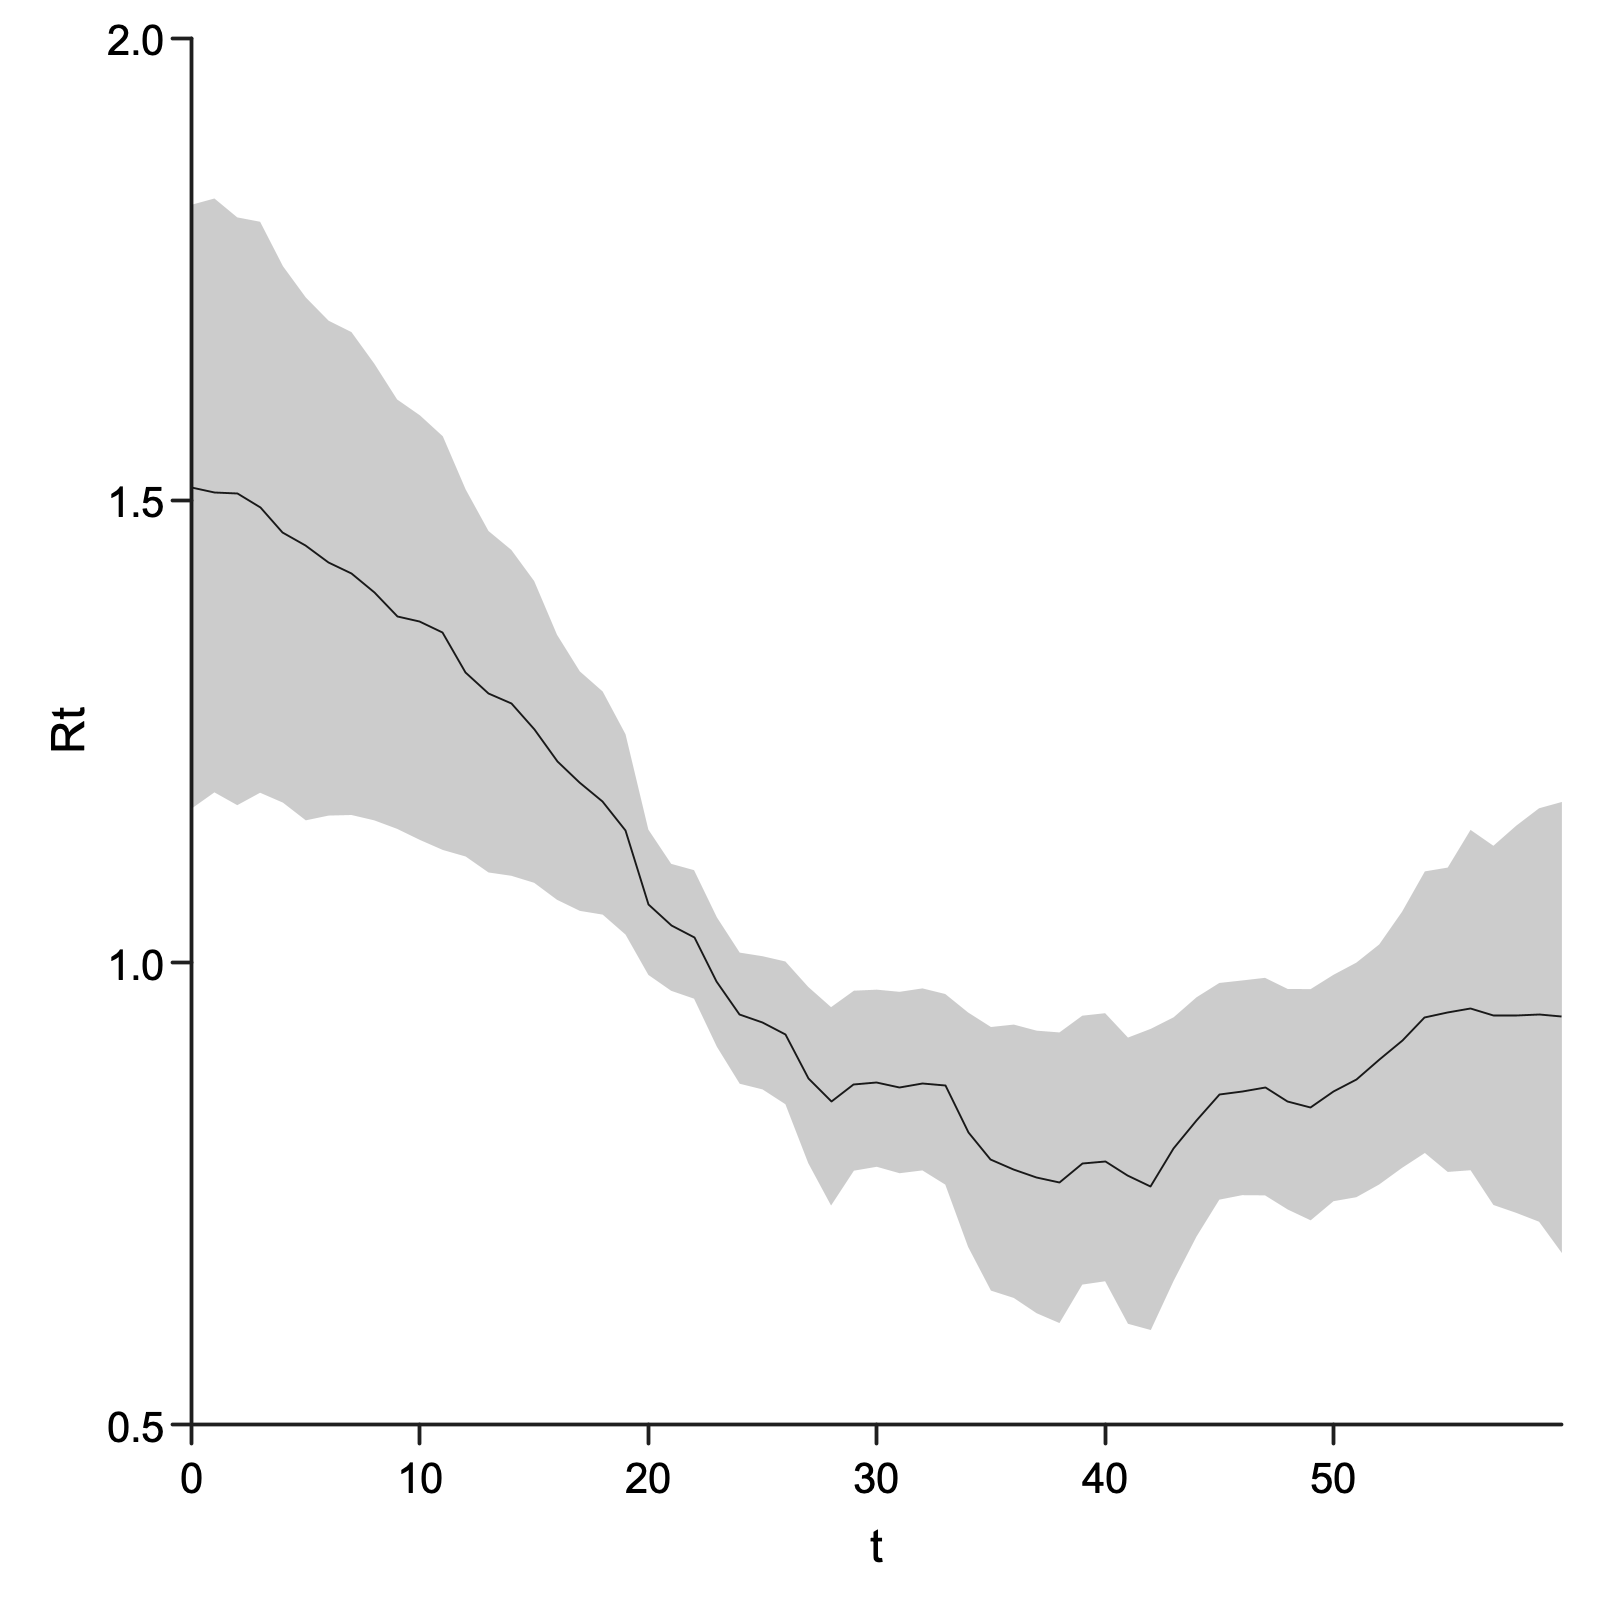

In [56]:
{{
    val countryName = "France"
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = time { 
        val res = predictRtOnset(onsetNumbers, pdelay, 60, failedRunDetection = false)
        res
    }
    val RtsDistributionStats(means, hdpis) = distributionStats(rts, estimates)
    show("t", "Rt", line(means), shade(hdpis))
//     show("serialInterval", density(serialEstimates))
}}

In [28]:
// co
val countriesTriedOneMoreTime = failedToConverge.toSeq.diff(Seq("Lithuania")) map { countryName =>
    println(countryName)
    val onsetNumbers = countriesOnsetData.collect {
        case m if m("country") == countryName => m("Onset").toDouble.round
    }
    val RtModelEstimates(rts,estimates, serialInterval, serialEstimates) = time { 
        val res = predictRtOnset(onsetNumbers.takeRight(50), pdelay, failedRunDetection = false)
        res
    }
    countryName -> distributionStats(rts, estimates)
}

Poland


Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.83 E-BFMI: 0.65 Step size: 0.04 Total gradient evaluations: 2e+05 (14us) Total time: 6s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.84 E-BFMI: 0.69 Step size: 0.04 Total gradient evaluations: 2e+05 (14us) Total time: 5s

Elapsed time: 12077 ms
Spain


Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.82 E-BFMI: 0.57 Step size: 0.01 Total gradient evaluations: 2e+05 (12us) Total time: 5s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.87 E-BFMI: 0.44 Step size: 0.01 Total gradient evaluations: 2e+05 (12us) Total time: 5s

Elapsed time: 11446 ms
Russia


Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.87 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (12us) Total time: 5s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.85 E-BFMI: 0.64 Step size: 0.01 Total gradient evaluations: 2e+05 (13us) Total time: 5s

Elapsed time: 11003 ms
Denmark


Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.81 E-BFMI: 0.76 Step size: 0.04 Total gradient evaluations: 2e+05 (13us) Total time: 5s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.80 E-BFMI: 0.73 Step size: 0.04 Total gradient evaluations: 2e+05 (14us) Total time: 5s

Elapsed time: 11466 ms
Italy


Chain 1 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.84 E-BFMI: 0.55 Step size: 0.02 Total gradient evaluations: 2e+05 (12us) Total time: 5s

Chain 2 Complete : Iteration: 1000 (2ms) Acceptance rate: 0.89 E-BFMI: 0.51 Step size: 0.02 Total gradient evaluations: 2e+05 (15us) Total time: 5s

Elapsed time: 11110 ms


countriesTriedOneMoreTime: Seq[(String, RtsDistributionStats)] = List(
  (
    "Poland",
    RtsDistributionStats(
      Vector(
        (0, 1.3888058194413306),
        (1, 1.382506231542669),
        (2, 1.3737949796951927),
        (3, 1.3684745751482787),
        (4, 1.3486629878467353),
        (5, 1.3384263621816406),
        (6, 1.3181939408383592),
        (7, 1.299268217360276),
        (8, 1.2888596437240372),
        (9, 1.2689590136439857),
        (10, 1.247251237779322),
        (11, 1.2222383880648193),
        (12, 1.1999070785108688),
        (13, 1.17946077956522),
        (14, 1.1567876606338237),
        (15, 1.1330034180567108),
        (16, 1.1096692170852762),
        (17, 1.0854228642918156),
        (18, 1.0614519786381418),
        (19, 1.0322176862509842),
        (20, 1.0138194657335078),
        (21, 0.9974511813878056),
        (22, 0.9880571317449904),
        (23, 0.9796294087511866),
        (24, 0.9793150855319259),
        (25, 0.9753731960202832),
  

In [29]:
val finalCountryStatsOnset = (countryStatsOnset collect {
    case (countryName, Right(stats)) => countryName -> stats
}) ++ countriesTriedOneMoreTime

finalCountryStatsOnset: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.3888058194413306),
      (1, 1.382506231542669),
      (2, 1.3737949796951927),
      (3, 1.3684745751482787),
      (4, 1.3486629878467353),
      (5, 1.3384263621816406),
      (6, 1.3181939408383592),
      (7, 1.299268217360276),
      (8, 1.2888596437240372),
      (9, 1.2689590136439857),
      (10, 1.247251237779322),
      (11, 1.2222383880648193),
      (12, 1.1999070785108688),
      (13, 1.17946077956522),
      (14, 1.1567876606338237),
      (15, 1.1330034180567108),
      (16, 1.1096692170852762),
      (17, 1.0854228642918156),
      (18, 1.0614519786381418),
      (19, 1.0322176862509842),
      (20, 1.0138194657335078),
      (21, 0.9974511813878056),
      (22, 0.9880571317449904),
      (23, 0.9796294087511866),
      (24, 0.9793150855319259),
      (25, 0.9753731960202832),
      (26, 0.9729253504738756),
      (27, 0.9698950618385724),
      

In [30]:
// override the previous variable so the rest of the notebook works fine
val countryStatsOnset = finalCountryStatsOnset

countryStatsOnset: Map[String, RtsDistributionStats] = Map(
  "Poland" -> RtsDistributionStats(
    Vector(
      (0, 1.3888058194413306),
      (1, 1.382506231542669),
      (2, 1.3737949796951927),
      (3, 1.3684745751482787),
      (4, 1.3486629878467353),
      (5, 1.3384263621816406),
      (6, 1.3181939408383592),
      (7, 1.299268217360276),
      (8, 1.2888596437240372),
      (9, 1.2689590136439857),
      (10, 1.247251237779322),
      (11, 1.2222383880648193),
      (12, 1.1999070785108688),
      (13, 1.17946077956522),
      (14, 1.1567876606338237),
      (15, 1.1330034180567108),
      (16, 1.1096692170852762),
      (17, 1.0854228642918156),
      (18, 1.0614519786381418),
      (19, 1.0322176862509842),
      (20, 1.0138194657335078),
      (21, 0.9974511813878056),
      (22, 0.9880571317449904),
      (23, 0.9796294087511866),
      (24, 0.9793150855319259),
      (25, 0.9753731960202832),
      (26, 0.9729253504738756),
      (27, 0.9698950618385724),
      (28, 

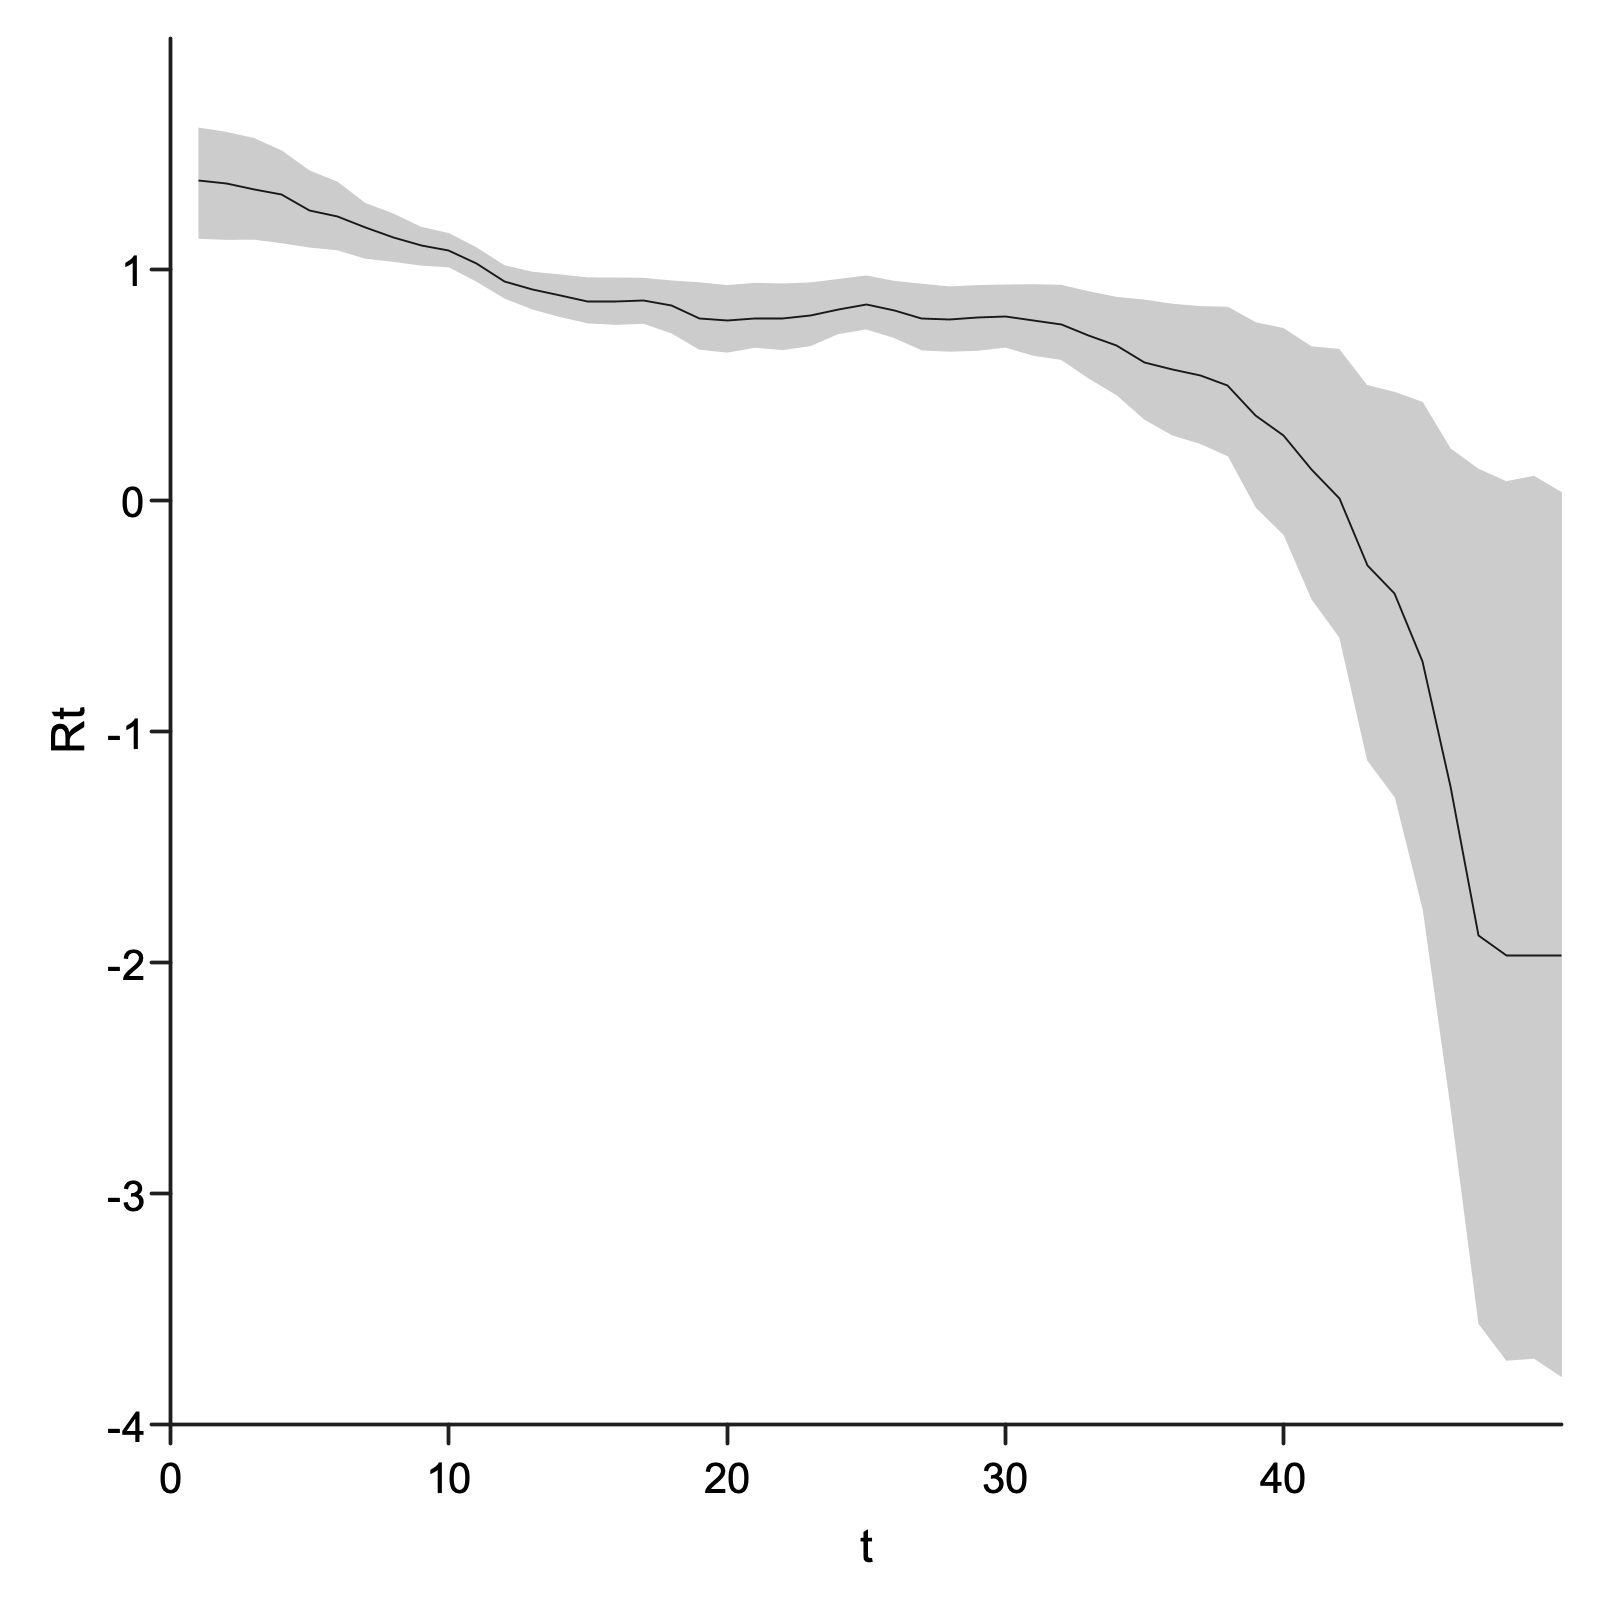

In [42]:
{{
    val RtsDistributionStats(means, hdpis) = countryStatsOnset("Spain")
    //  val RtsDistributionStats(means, hdpis) = countryStats("Austria")
    show("t", "Rt", line(means.takeRight(50)), shade(hdpis.takeRight(50)))
}}

In [32]:
def datesForCountry(country: String) = {
    /* countriesSmooth.collect {
        case m if m("country") == country => m("date")
    }*/
    countriesOnsetData.collect {
        case m if m("country") == country => m("date")
    }
}

defined function datesForCountry

In [37]:
def writeStatsToCsv(country: String, stats: RtsDistributionStats, csvWriter: CSVWriter): Unit = {
    val xs = stats.means.unzip._2 zip stats.hdpis.unzip._2
    val dates = datesForCountry(country).takeRight(51) // takeRight is a hack
    assert(xs.size == dates.size, s"${xs.size} != ${dates.size}")
    (xs zip dates) foreach {
        case ((mean, (low90, high90)), date) => 
            csvWriter.writeRow(country :: date :: mean.toString :: low90.toString :: high90.toString :: Nil)
    }
}

defined function writeStatsToCsv

In [38]:
val csvWriter = CSVWriter.open(new File("data/rt-rainierOnset.csv")) // rt-rainier.csv

csvWriter: CSVWriter = com.github.tototoshi.csv.CSVWriter@51e104fd

In [39]:
csvWriter.writeRow(List("country", "date", "ML", "Low_90", "High_90"))

In [40]:
// countryStats.toList.sortBy(_._1).foreach {
countryStatsOnset.toList.sortBy(_._1).foreach {
    case (country, stats) => writeStatsToCsv(country, stats, csvWriter)
}

In [41]:
csvWriter.close()

Changes from the original model:
* run the markov process with log(R_t) to ensure that it always stays positive
* use a Laplace transition to strongly regularize
* put a prior on the std dev of the transition, rather than fixing it
* put a prior on the serial interval rather than fixing it

In [ ]:
val (model, rts) =  {
    val (xs, ys) = data.unzip

    val serialInterval = Normal(5,2).latent
    val logR0 = Normal(0, 1).latent
    val sigma = Exponential(10).latent
    val diffs = Laplace(0,sigma).latentVec(data.size)
    val logRts = Vec.from(diffs.toList.scanLeft(logR0)(_ + _))
    val likelihoods = Vec.from(xs).map{case (i, kt_prev) => 
        val lambda = ((logRts(i).exp - 1)/serialInterval).exp * kt_prev
        Poisson(lambda)
    }

    (Model.observe(ys, likelihoods), logRts.map(_.exp))
}

This seems to work best (and fastest) with a dead simple HMC(100) sampler, no mass matrix or path length adapation.

In [ ]:
val samplerConfig = new DefaultConfig {
    override def massMatrixTuner() = new IdentityMassMatrixTuner
    override def sampler() = new HMCSampler(100)
}
val trace = model.sample(samplerConfig, 2)

In [ ]:
{{
    val rtForecasts = trace.predict(rts)
    val means = 0.until(rts.size).map{i => (i,mean(rtForecasts.map(_(i))))}
    val hdpis = 0.until(rts.size).map{i => (i, hdpi(rtForecasts.map(_(i))))}
    show("t", "Rt", line(means), shade(hdpis))
}}

In [ ]:
rts